# Keras를 활용한 손글씨 인식 cnn 모델 구현 실습

###목표   
손글씨 이미지를 입력값으로 넣어주면 모델이 인식하여 숫자 0~9 사이의 정확한 output 출력  
  
###데이터 준비와 전처리  
MNIST Dataset  
총 70,000개의 손글씨 숫자(0 ~ 9 digits) 이미지로 구성.  
그중 60,000개는 모델을 훈련시킬 때 쓰일 Training data이고 10,000개는 모델을 테스트할 때 쓰일 Test data로 이루어짐  
  
Keras를 이용해 데이터 호출  
train_images 모델 트레이닝을 위한 28x28크기의 matrix로 표현된 이미지 60,000개  
train_labels 모델 트레이닝을 위한 60,000개의 숫자(integer 0 ~ 9) 라벨(label)
모델 구현 후 테스팅을 위한 28x28크기의 matrix로 표현된 이미지 10,000개   
test_labels 모델 구현 후 테스팅을 위한 10,000개의 숫자(integer 0~9) 라벨  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 관련 라이브러리 선언
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 학습 데이터 불러오기 및 전처리
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
train_images[0].dtype

dtype('float64')

In [5]:
# 이미지 전처리
# 이미지 데이터(x값) 모양을 28x28에서 28x28x1로 reshape 
train_images_vec= train_images.reshape((60000,28,28,1))
test_images_vec= test_images.reshape((10000,28,28,1))

In [6]:
# 라벨 전처리(0~9 integer). 원핫인코딩
# One-hot Encoding 단 하나의 값만 1(true)이고 나머지 값은 모두 0(false)인 데이터 형태를 의미. 컴퓨터가 인식하고 학습하기에 용이하게해줌
def one_hot_encoding(labels,demension=10):
  res = np.zeros((len(labels),demension)) 
  for i , label in enumerate(labels): # enumerate로 리스트에 인덱스(i) 부여
    res[i,label] = 1.
  return res

train_labels_vec = one_hot_encoding(train_labels)
test_labels_vec = one_hot_encoding(test_labels)

print(train_labels_vec.shape)
print(test_labels_vec.shape)

(60000, 10)
(10000, 10)


In [7]:
# 비교용. 원핫 처리 전후
print(train_labels[2])
print(train_labels_vec[2])

4
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


training data의 일부분을 잘라 validation 데이터 만들어주기  
validation data는 중간 트레이닝 검증 목적으로 overfitting 방지 효과  
1/5 떼서 넣음

In [8]:
rand_indices = np.random.permutation(60000)
valid_indices = rand_indices[50000:60000]
train_indices = rand_indices[0:50000]

train_images_valid = train_images_vec[valid_indices, :, :, :]  # valid
train_labels_valid = train_labels_vec[valid_indices, :]

train_images_vec = train_images_vec[train_indices, :, :, :] # 업뎃
train_labels_vec = train_labels_vec[train_indices, :]

print(train_images_valid.shape) 
print(train_labels_valid.shape) # validation data = 10000
print(train_images_vec.shape)
print(train_labels_vec.shape) # training data = 50000

(10000, 28, 28, 1)
(10000, 10)
(50000, 28, 28, 1)
(50000, 10)


분류 완료  
트레이닝 50000  
발리데이션 10000  
테스트 데이터 10000  

모델 구현, 트레이닝

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(filters= 10, kernel_size=(5,5), activation='relu', input_shape=(28, 28, 1))) # Convolutional layer

model.add(layers.MaxPooling2D((2, 2))) # MaxPooling2D클래스
model.add(layers.Conv2D(filters= 20, kernel_size=(5,5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 64)                2

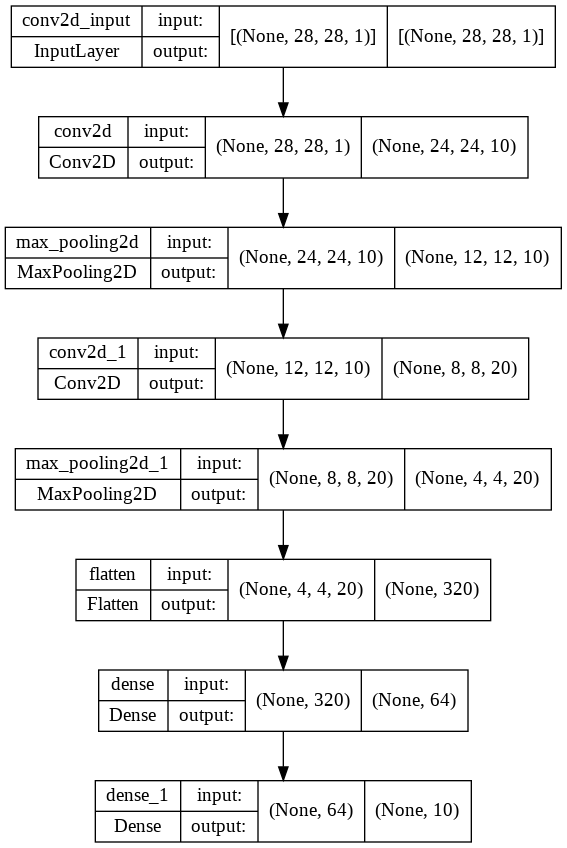

In [10]:
# CNN 네트워크 시각화
from tensorflow.keras.utils import plot_model
# from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

  베이스 라인 
  

In [14]:
# 훈련설정 Optimizer로 RMSprop을 사용
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=  RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
#fit메소드를 사용하여 모델 트레이닝 
# batch_size=128, epochs=50 
history = model.fit(train_images_valid, train_labels_valid, batch_size=128, epochs=30)

Epoch 1/30
79/79 [==============================] - 1s 4ms/step - loss: 0.1285 - accuracy: 0.9634
Epoch 2/30
79/79 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 0.9622
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 0.1213 - accuracy: 0.9638
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 0.1178 - accuracy: 0.9649
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 0.1138 - accuracy: 0.9659
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 0.1117 - accuracy: 0.9675
Epoch 7/30
79/79 [==============================] - 0s 4ms/step - loss: 0.1084 - accuracy: 0.9690
Epoch 8/30
79/79 [==============================] - 0s 4ms/step - loss: 0.1045 - accuracy: 0.9695
Epoch 9/30
79/79 [==============================] - 1s 7ms/step - loss: 0.1034 - accuracy: 0.9697
Epoch 10/30
79/79 [==============================] - 1s 7ms/step - loss: 0.1011 - accuracy: 0.9719
Epoch 11/30
79/79 [

모델 평가

In [19]:
# training data
model.evaluate(train_images_valid, train_labels_valid)

313/313 [==============================] - 1s 3ms/step - loss: 0.0659 - accuracy: 0.9818


[0.0658888891339302, 0.9818000197410583]

In [20]:
# test data
model.evaluate(test_images_vec, test_labels_vec)

313/313 [==============================] - 1s 3ms/step - loss: 0.0960 - accuracy: 0.9689


[0.09603606909513474, 0.9689000248908997]